# W266 Final Project - Evaluation of Models by Token Length

**Description:** 

- This notebook attempts to look at possible differences in performance of (a) the baseline LED model; (b) the baseline Centrum model; (c) the finetuned LED model; (d) the finetuned Centrum model; and (e) the naive two-step model, with respect to the rouge score, for samples with different token lengths.

# 1. Set-up

In [1]:
import evaluate
from pprint import pprint

## General plotting
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk

## Managing memory
import gc
import pickle

## Text processing
import re
import numpy as np
from scipy import stats as st

In [2]:
from datasets import load_dataset, load_metric

In [3]:
from transformers import AutoTokenizer

In [4]:
## Checking if GPU is available when running locally
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [5]:
## Loading rouge
rouge = load_metric("rouge")

C:\Users\JustinTo\AppData\Local\Temp\ipykernel_23232\4286193646.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


# 2. Loading X-Science Dataset (Test Set only)

## 2.1 Loading the dataset

In [6]:
## Loading the dataset
xsci_test = load_dataset('multi_x_science_sum', split='test')

## For text processing as X-Science have not concatenated the source articles
DOC_SEP = " ||||| "

Found cached dataset multi_x_science_sum (C:/Users/JustinTo/.cache/huggingface/datasets/multi_x_science_sum/default/1.1.0/2876ec0401f8f5c5acf7f4857dbc8d6229a390ab428321ab848f03f14b7f9729)


## 2.2 Preprocessing

- Tokenization is not necessary as all the answers from models/baseline to be compared to the test labels are already in text form.
- So, we only need to pre-process the X-Science dataset labels to the form we want, e.g. changing the citation numbers to @cite, etc.

In [7]:
pat = re.compile("@cite_[0-9]+")

In [8]:
def preprocess_dataset(example):
    output = {}
    output["abstracts"] = (
        example["abstract"].split("| Abstract: ")[-1]
        + DOC_SEP
        + DOC_SEP.join([x for x in example["ref_abstract"]["abstract"] if x])
    )
    output["related_work"] = pat.sub("@cite", example["related_work"])
    
    return output

In [9]:
def preprocess_dataset_batched(example):
    output = {}
    output["abstracts"] = []
    output["related_work"] = []
    output["main_article"] = []
    
    for abstract, ref_abstract in zip(
        example["abstract"], example["ref_abstract"]
    ):
        output["abstracts"].append(
            abstract.split("| Abstract: ")[-1]
            + DOC_SEP
            + DOC_SEP.join([x for x in ref_abstract["abstract"] if x])
        )
        
        # Main article added for calculating the degree of copying
        output["main_article"].append(abstract)
        
    for related_work in example["related_work"]:
        output["related_work"].append(pat.sub("@cite", related_work))
    
    return output

In [10]:
xsci_test_processed = xsci_test.map(
    # preprocess_dataset,
    preprocess_dataset_batched,
    remove_columns=xsci_test.column_names,
    batched=True,
    batch_size=1,
    )

Parameter 'function'=<function preprocess_dataset_batched at 0x000001FB46EA54C0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/5093 [00:00<?, ?ba/s]

## 2.3 Separating the Dataset into Short, Medium & Long Input Length Samples

In [11]:
def get_tokenizer(host_tokenizer: str):
    """return the tokenizer and model for LLM training"""

    return AutoTokenizer.from_pretrained(host_tokenizer, 
                                         use_cache=False, 
                                         gradient_checkpointing=True)


centrum_tokenizer = get_tokenizer("ratishsp/Centrum")

centrum_tokenizer.add_tokens(DOC_SEP, special_tokens=True)

1

In [12]:
## Estimating the token length of the test data set
len_inputs = []
len_labels = []
num_articles = []

for sample in xsci_test_processed['abstracts']:
    temp = centrum_tokenizer(sample, return_tensors="pt")
    len_inputs.append(temp.input_ids.shape[1])
    num_articles.append((sample.count(DOC_SEP)+1))

for sample in xsci_test_processed['related_work']:
    temp = centrum_tokenizer(sample, return_tensors="pt")
    len_labels.append(temp.input_ids.shape[1])
                        
assert len(len_inputs) == len(len_labels) == len(num_articles)

print(f"Completed, number of samples processed is: {len(len_inputs)}")

Completed, number of samples processed is: 5093


In [13]:
## Showing quartiles
q1 = np.quantile(len_inputs, [0,0.25,0.5,0.75,1])
q2 = np.quantile(len_labels, [0,0.25,0.5,0.75,1])
q3 = np.quantile(num_articles, [0,0.25,0.5,0.75,1])

print(f"The quartiles in terms of input lengths are: {(q1[1], q1[2], q1[3])}")
print(f"The quartiles in terms of label lengths are: {(q2[1], q2[2], q2[3])}")
print(f"The quartiles in terms of number of articles are: {(q3[1], q3[2], q3[3])}")

The quartiles in terms of input lengths are: (486.0, 735.0, 1150.0)
The quartiles in terms of label lengths are: (96.0, 138.0, 184.0)
The quartiles in terms of number of articles are: (2.0, 4.0, 6.0)


In [14]:
## Breaking up test set into three parts: short (<lower quartile); medium (in between quartiles); long (>upper quartile)
short_samples = xsci_test_processed.select(np.where(len_inputs < q1[1])[0])
medium_samples = xsci_test_processed.select(np.where(np.logical_and(q1[1]<=len_inputs, len_inputs < q1[3]))[0])
long_samples = xsci_test_processed.select(np.where(len_inputs >= q1[3])[0])

short_samples, medium_samples, long_samples

(Dataset({
     features: ['related_work', 'abstracts', 'main_article'],
     num_rows: 1273
 }),
 Dataset({
     features: ['related_work', 'abstracts', 'main_article'],
     num_rows: 2546
 }),
 Dataset({
     features: ['related_work', 'abstracts', 'main_article'],
     num_rows: 1274
 }))

# 3. Evaluation by Data Subsets

## 3.1 Common Evaluation Function

In [15]:
def score_evalautor(generated_answers):
    '''
    Function that scores:
    (a) a full rouge score metric compared to the X-sci dataset labels; and
    (b) a rouge-L metric compared to the "main article" of each dataset lavel.
    
    generated_answers: list of generated summaries from a model, in the form of a list or otherwise acceptable to rouge.    
    '''
    results = {}
    subsets = {
        'Short':  short_samples,
        'Medium': medium_samples,
        'Long':   long_samples
    }
    data_locs = {
        'Short':  np.where(len_inputs < q1[1])[0],
        'Medium': np.where(np.logical_and(q1[1]<=len_inputs, len_inputs < q1[3]))[0],
        'Long':   np.where(len_inputs >= q1[3])[0]
    }
    
    # Calculate overall results
    results['Overall'] = {}
    results['Overall']['Rouge'] = rouge.compute(predictions=generated_answers,
                                  references=[ref for ref in xsci_test_processed['related_work']],
                                  use_stemmer = True)
    results['Overall']['Copying'] = rouge.compute(predictions=generated_answers,
                                    references=[ref for ref in xsci_test_processed['main_article']],
                                    rouge_types=['rougeL', 'rougeLsum'],
                                    use_stemmer = True)
    
    # Calculate scores for datasubsets
    for length in ['Short', 'Medium', 'Long']:
        results[length] = {}
        results[length]['Rouge'] = rouge.compute(predictions=[generated_answers[idx] for idx in data_locs[length]],
                                   references=[ref for ref in subsets[length]['related_work']],
                                   use_stemmer = True)
        results[length]['Copying'] = rouge.compute(predictions=[generated_answers[idx] for idx in data_locs[length]],
                                     references=[ref for ref in subsets[length]['main_article']],
                                     use_stemmer = True)
    return results

## 3.2 Actual Evaluation

In [16]:
## Overall dictionary to store results
scores = {}

In [36]:
## for loading previous results when adding additional datapoints
with open("misc_data/score_comparisons_9April.pkl", "rb") as f:
    scores = pickle.load(f)
    
scores.keys()

dict_keys(['Naive_baseline', 'BaseLED_1024', 'BaseLED_16384', 'LargeLED_1024', 'LargeLED_16384', 'BaseCentrum_1024', 'BaseCentrum_4096', 'FinetunedLED', 'FinetunedCentrum', '2Step_LED', '2Step_Centrum'])

### 3.2.1 Naive Baselines (First 3 Sentences of Main Article)

In [108]:
punkt_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
naive_baselines = [
    " ".join(
        [
            " ".join(punkt_tokenizer.tokenize(each)[:2]).strip()
            for each in element["abstracts"].split("|||||")
        ]
    ).strip()
    for element in xsci_test_processed
]

In [121]:
scores['Naive_baseline'] = score_evalautor(naive_baselines)

### 3.2.2 Off-the-shelf Base LED (1024 Token Length)

In [129]:
# Loading previously saved answers
with open("answers_revised/baselines/LED_base_1024tokens.pkl", "rb") as f:
    answers = pickle.load(f)

In [130]:
scores['BaseLED_1024'] = score_evalautor(answers)

### 3.2.3 Off-the-shelf Base LED (16384 Token Length)

In [134]:
# Loading previously saved answers
with open("answers_revised/baselines/LED_base_16384tokens.pkl", "rb") as f:
    answers = pickle.load(f)

In [135]:
scores['BaseLED_16384'] = score_evalautor(answers)

### 3.2.4 Off-the-shelf Large LED (1024 Token Length)

In [136]:
# Loading previously saved answers
with open("answers_revised/baselines/LED_large_1024tokens.pkl", "rb") as f:
    answers = pickle.load(f)

In [137]:
scores['LargeLED_1024'] = score_evalautor(answers)

### 3.2.5 Off-the-shelf Large LED (16384 Token Length)

In [138]:
# Loading previously saved answers
with open("answers_revised/baselines/LED_large_16384tokens.pkl", "rb") as f:
    answers = pickle.load(f)

In [139]:
scores['LargeLED_16384'] = score_evalautor(answers)

### 3.2.6 Finetuned LED (Epoch=1.5; No_repeat_ngram=4)

In [140]:
# Loading previously saved answers
with open("answers_revised/epoch2/LED_xsci_finetuned_run10.pkl", "rb") as f:
    answers = pickle.load(f)

In [141]:
scores['FinetunedLED'] = score_evalautor(answers)

### 3.2.7 Finetuned Centrum (Epoch=2; No_repeat_ngram=4)

In [142]:
# Loading previously saved answers
with open("answers_revised/centrum/Centrum_finetuned_norepeat4_run2.pkl", "rb") as f:
    answers = pickle.load(f)

In [143]:
scores['FinetunedCentrum'] = score_evalautor(answers)

### 3.2.8 Naive Two-Step Model (With Finetuned LED as Second Model)

In [144]:
# Loading previously saved answers
with open("misc_data/XSci_test_second_step_answers.pkl", "rb") as f:
    answers = pickle.load(f)

In [145]:
scores['2Step_LED'] = score_evalautor(answers)

### 3.2.9 Naive Two-Step Model (With Finetuned Centrum as Second Model)

In [147]:
# Loading previously saved answers
with open("misc_data/XSci_test_2step_CENTRUM.pkl", "rb") as f:
    answers = pickle.load(f)

In [148]:
scores['2Step_Centrum'] = score_evalautor(answers)

### 3.2.10 Baseline Centrum (1024 tokens; No_repeat_ngram=4)

In [24]:
# Loading previously saved answers
with open("answers_revised/baselines/Centrum_1024tokens_norepeat4.pkl", "rb") as f:
    answers = pickle.load(f)

In [25]:
scores['BaseCentrum_1024'] = score_evalautor(answers)

### 3.2.11 Baseline Centrum (4096 tokens; No_repeat_ngram=4)

In [26]:
# Loading previously saved answers
with open("answers_revised/baselines/Centrum_4096tokens.pkl", "rb") as f:
    answers = pickle.load(f)

In [27]:
scores['BaseCentrum_4096'] = score_evalautor(answers)

## 3.3 Saving Results

In [150]:
# Saving the scores dictionary
with open("misc_data/score_comparisons.pkl", "wb") as f:
    pickle.dump(scores, f)

In [35]:
# Saving the scores dictionary (after adding base centrum on 9 April)
with open("misc_data/score_comparisons_9April.pkl", "wb") as f:
    pickle.dump(reordered_scores, f)

In [37]:
# Converting to a dataframe for saving as well
scores_df = pd.DataFrame()

for model in scores.keys():
    for subset in scores[model].keys():
        for metric in scores[model][subset].keys():
            for rouge_type in scores[model][subset][metric].keys():
                for (idx, lmh) in enumerate(['low', 'mid', 'high']):
                    for (idx2, prf) in enumerate(['precision', 'recall', 'f-measure']):
                        df_to_add = {
                            'Model': model,
                            'Dataset': subset,
                            'Metric': metric,
                            'Rouge_Type': rouge_type,
                            'Low/Mid/High': lmh,
                            'Prec/Recall/F1':prf,
                            'Score': scores[model][subset][metric][rouge_type][idx][idx2]
                        }
                        scores_df = pd.concat([scores_df, pd.DataFrame.from_dict(df_to_add, orient='index').T],
                                              ignore_index = True)

scores_df.reset_index()

with open("misc_data/score_comparisons_df_9Apr.pkl", "wb") as f:
    pickle.dump(scores_df, f)

# 4. Comparing Results

## 4.1 Comparing Rouge Scores

### 4.1.1 Rouge-1 Scores

In [38]:
sub_df1 = scores_df.loc[(scores_df['Metric'] == 'Rouge') &
                       (scores_df['Rouge_Type'] == 'rouge1') &
                       (scores_df['Low/Mid/High'] == 'mid')]

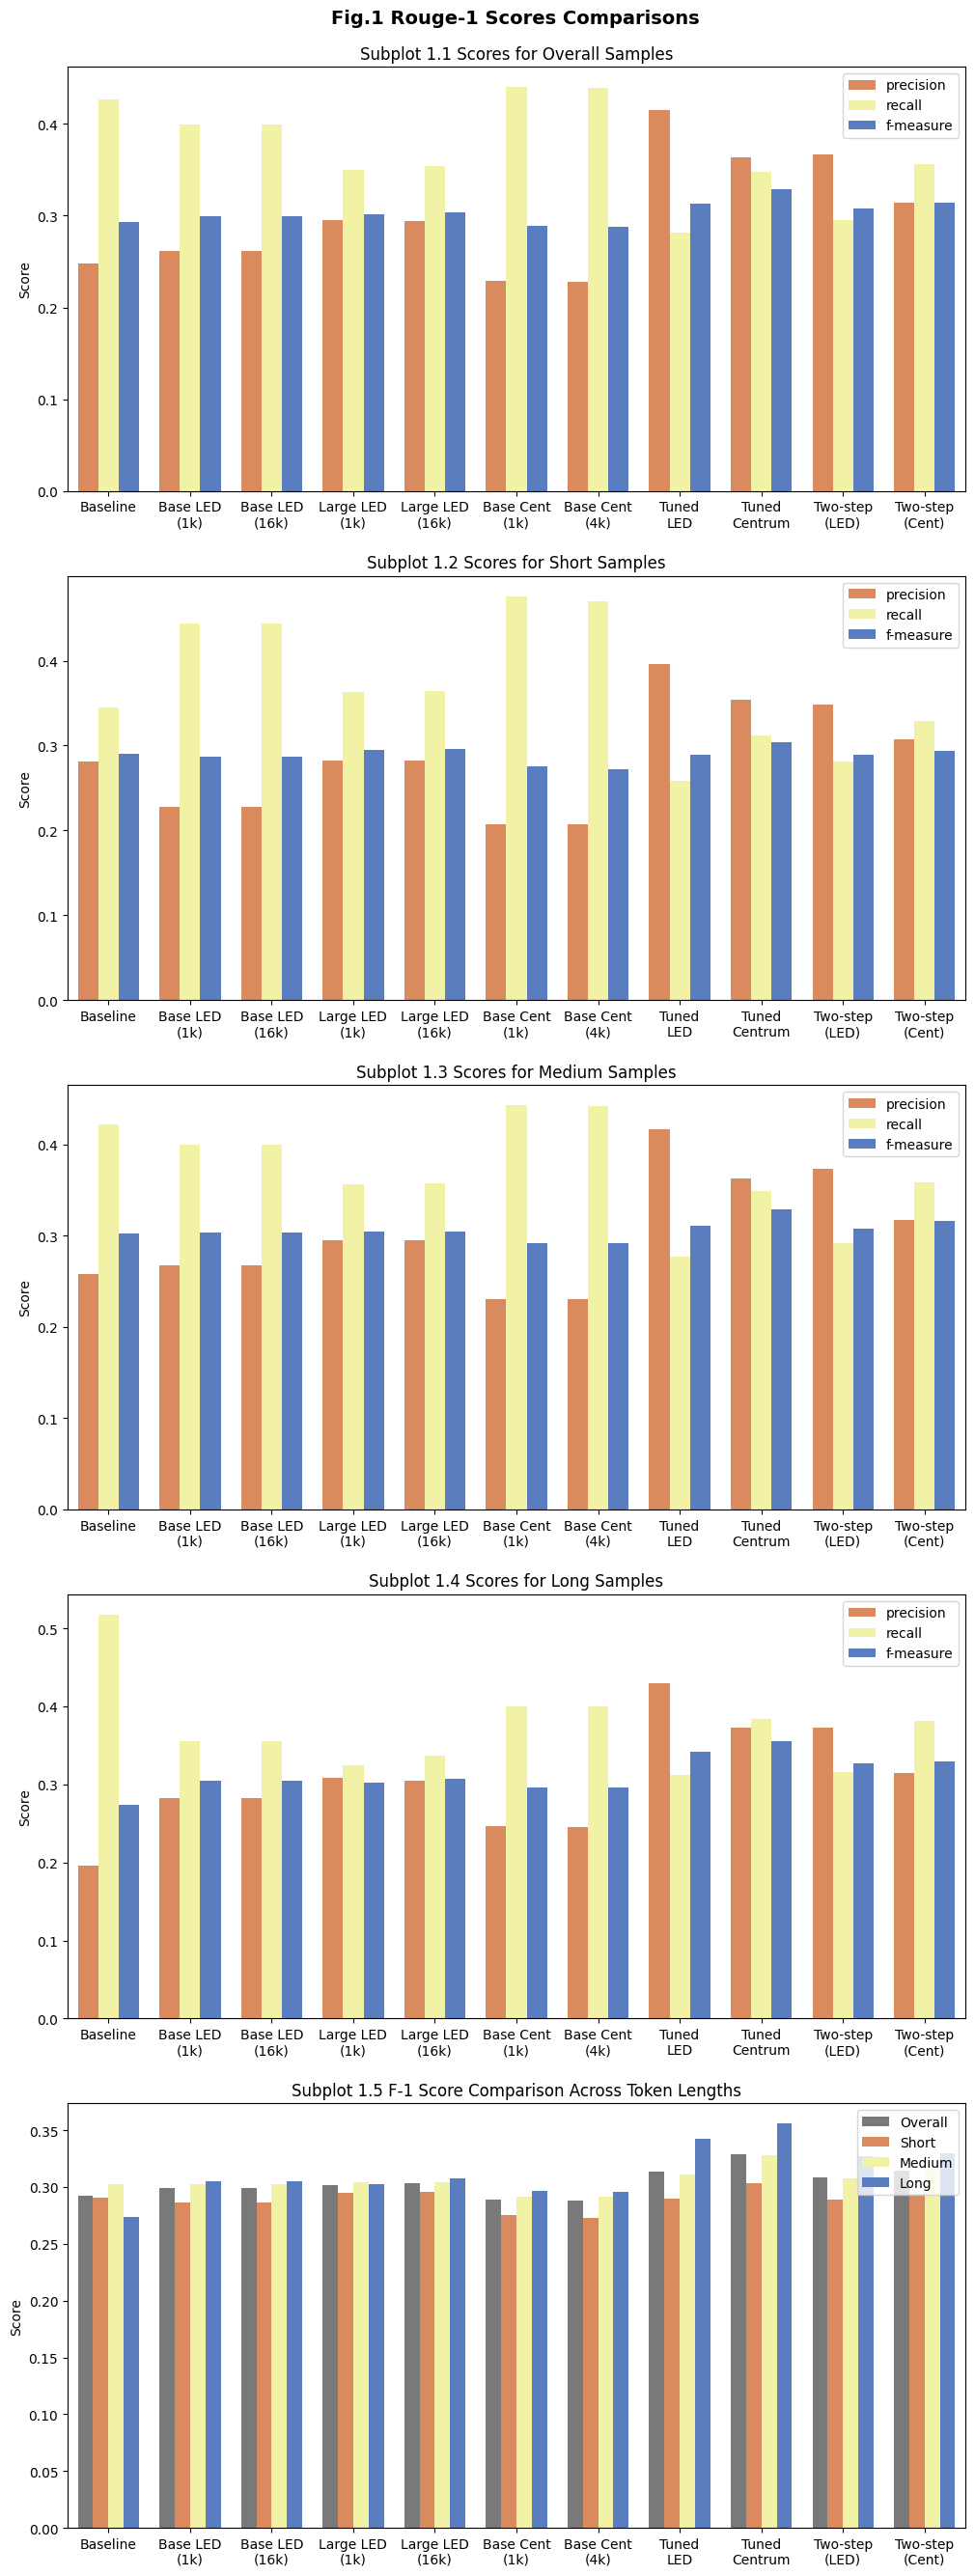

In [43]:
## Plotting results
fig, axes = plt.subplots(5, figsize=(12,30))

fig.suptitle('    Fig.1 Rouge-1 Scores Comparisons',
             size=14,
             fontweight="bold")
plt.subplots_adjust(top=0.96)

for idx, subset in enumerate(['Overall', 'Short', 'Medium', 'Long']):
    sns.barplot(data=sub_df1.loc[sub_df1['Dataset'] == subset],
                x="Model",
                y="Score",
                hue="Prec/Recall/F1",
                ax=axes[idx],
                width=0.75,
                palette=[sns.color_palette("muted")[1],
                         sns.color_palette("Paired")[10],
                         sns.color_palette("muted")[0]])
    axes[idx].set_title(f'Subplot 1.{idx+1} Scores for {subset} Samples')
    axes[idx].set(xlabel=None)
    axes[idx].set_xticklabels(labels=['Baseline',
                                      'Base LED\n(1k)',
                                      'Base LED\n(16k)',
                                      'Large LED\n(1k)',
                                      'Large LED\n(16k)',
                                      'Base Cent\n(1k)',
                                      'Base Cent\n(4k)',
                                      'Tuned\nLED',
                                      'Tuned\nCentrum',
                                      'Two-step\n(LED)',
                                      'Two-step\n(Cent)'])
    axes[idx].legend(loc=1)
    
sns.barplot(data=sub_df1.loc[sub_df1['Prec/Recall/F1'] == "f-measure"],
            x="Model",
            y="Score",
            hue="Dataset",
            ax=axes[4],
            width=0.75,
            palette=[sns.color_palette("muted")[7],
                     sns.color_palette("muted")[1],
                     sns.color_palette("Paired")[10],
                     sns.color_palette("muted")[0]])
axes[4].set_title(f'Subplot 1.5 F-1 Score Comparison Across Token Lengths')
axes[4].set(xlabel=None)
axes[4].set_xticklabels(labels=['Baseline',
                                  'Base LED\n(1k)',
                                  'Base LED\n(16k)',
                                  'Large LED\n(1k)',
                                  'Large LED\n(16k)',
                                  'Base Cent\n(1k)',
                                  'Base Cent\n(4k)',
                                  'Tuned\nLED',
                                  'Tuned\nCentrum',
                                  'Two-step\n(LED)',
                                  'Two-step\n(Cent)'])
axes[4].legend(loc=1)


### 4.1.2 Rouge-2 Scores

In [44]:
sub_df2 = scores_df.loc[(scores_df['Metric'] == 'Rouge') &
                        (scores_df['Rouge_Type'] == 'rouge2') &
                        (scores_df['Low/Mid/High'] == 'mid')]

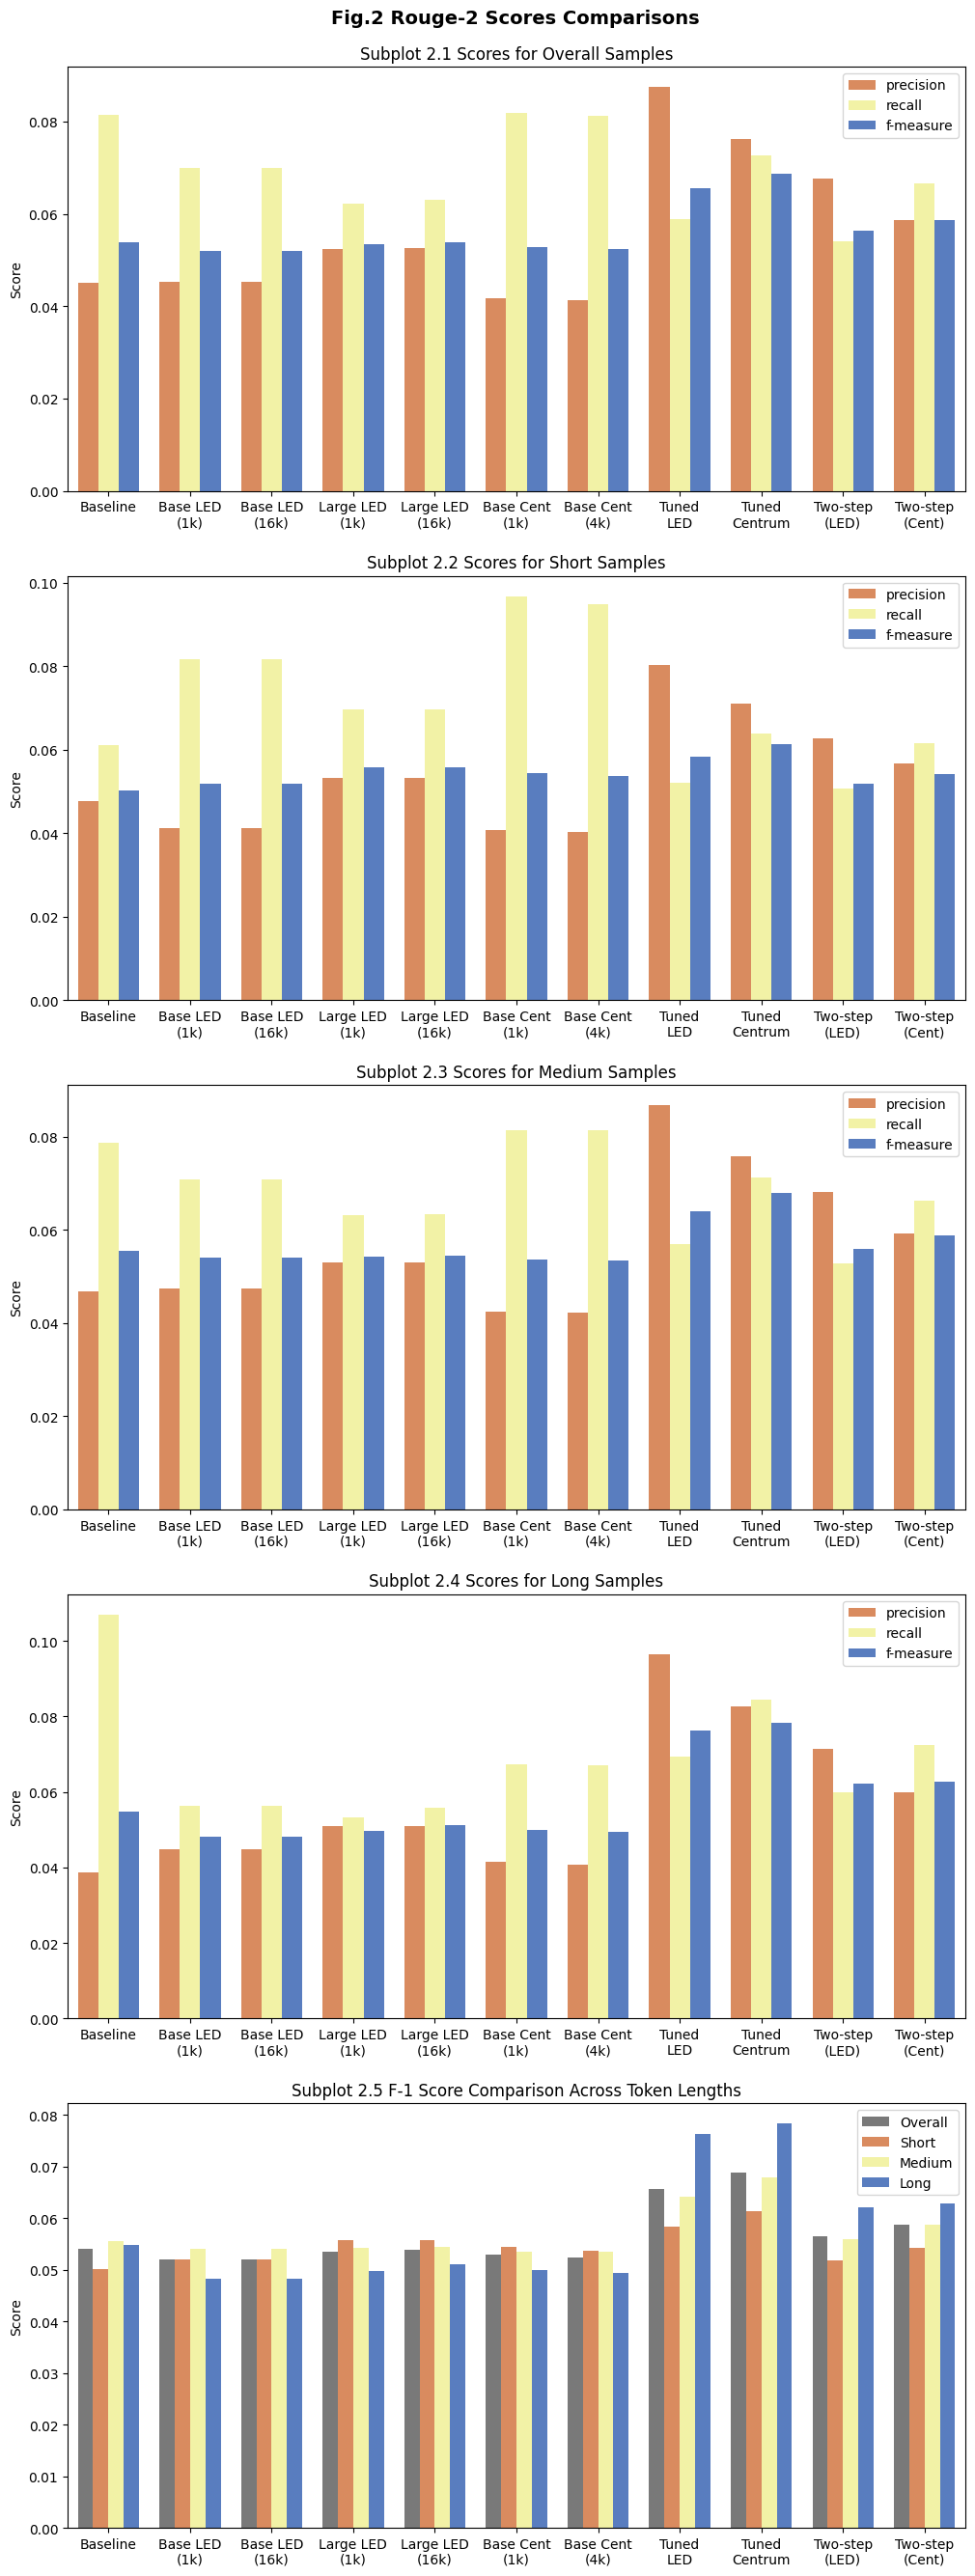

In [46]:
## Plotting results
fig, axes = plt.subplots(5, figsize=(12,30))

fig.suptitle('    Fig.2 Rouge-2 Scores Comparisons',
             size=14,
             fontweight="bold")
plt.subplots_adjust(top=0.96)

for idx, subset in enumerate(['Overall', 'Short', 'Medium', 'Long']):
    sns.barplot(data=sub_df2.loc[sub_df2['Dataset'] == subset],
                x="Model",
                y="Score",
                hue="Prec/Recall/F1",
                ax=axes[idx],
                width=0.75,
                palette=[sns.color_palette("muted")[1],
                         sns.color_palette("Paired")[10],
                         sns.color_palette("muted")[0]])
    axes[idx].set_title(f'Subplot 2.{idx+1} Scores for {subset} Samples')
    axes[idx].set(xlabel=None)
    axes[idx].set_xticklabels(labels=['Baseline',
                                      'Base LED\n(1k)',
                                      'Base LED\n(16k)',
                                      'Large LED\n(1k)',
                                      'Large LED\n(16k)',
                                      'Base Cent\n(1k)',
                                      'Base Cent\n(4k)',
                                      'Tuned\nLED',
                                      'Tuned\nCentrum',
                                      'Two-step\n(LED)',
                                      'Two-step\n(Cent)'])
    axes[idx].legend(loc=1)
    
sns.barplot(data=sub_df2.loc[sub_df2['Prec/Recall/F1'] == "f-measure"],
            x="Model",
            y="Score",
            hue="Dataset",
            ax=axes[4],
            width=0.75,
            palette=[sns.color_palette("muted")[7],
                     sns.color_palette("muted")[1],
                     sns.color_palette("Paired")[10],
                     sns.color_palette("muted")[0]])
axes[4].set_title(f'Subplot 2.5 F-1 Score Comparison Across Token Lengths')
axes[4].set(xlabel=None)
axes[4].set_xticklabels(labels=['Baseline',
                                'Base LED\n(1k)',
                                'Base LED\n(16k)',
                                'Large LED\n(1k)',
                                'Large LED\n(16k)',
                                'Base Cent\n(1k)',
                                'Base Cent\n(4k)',
                                'Tuned\nLED',
                                'Tuned\nCentrum',
                                'Two-step\n(LED)',
                                'Two-step\n(Cent)'])
axes[4].legend(loc=1)

### 4.1.3 Rouge-L Scores

In [47]:
sub_df3 = scores_df.loc[(scores_df['Metric'] == 'Rouge') &
                        (scores_df['Rouge_Type'] == 'rougeL') &
                        (scores_df['Low/Mid/High'] == 'mid')]

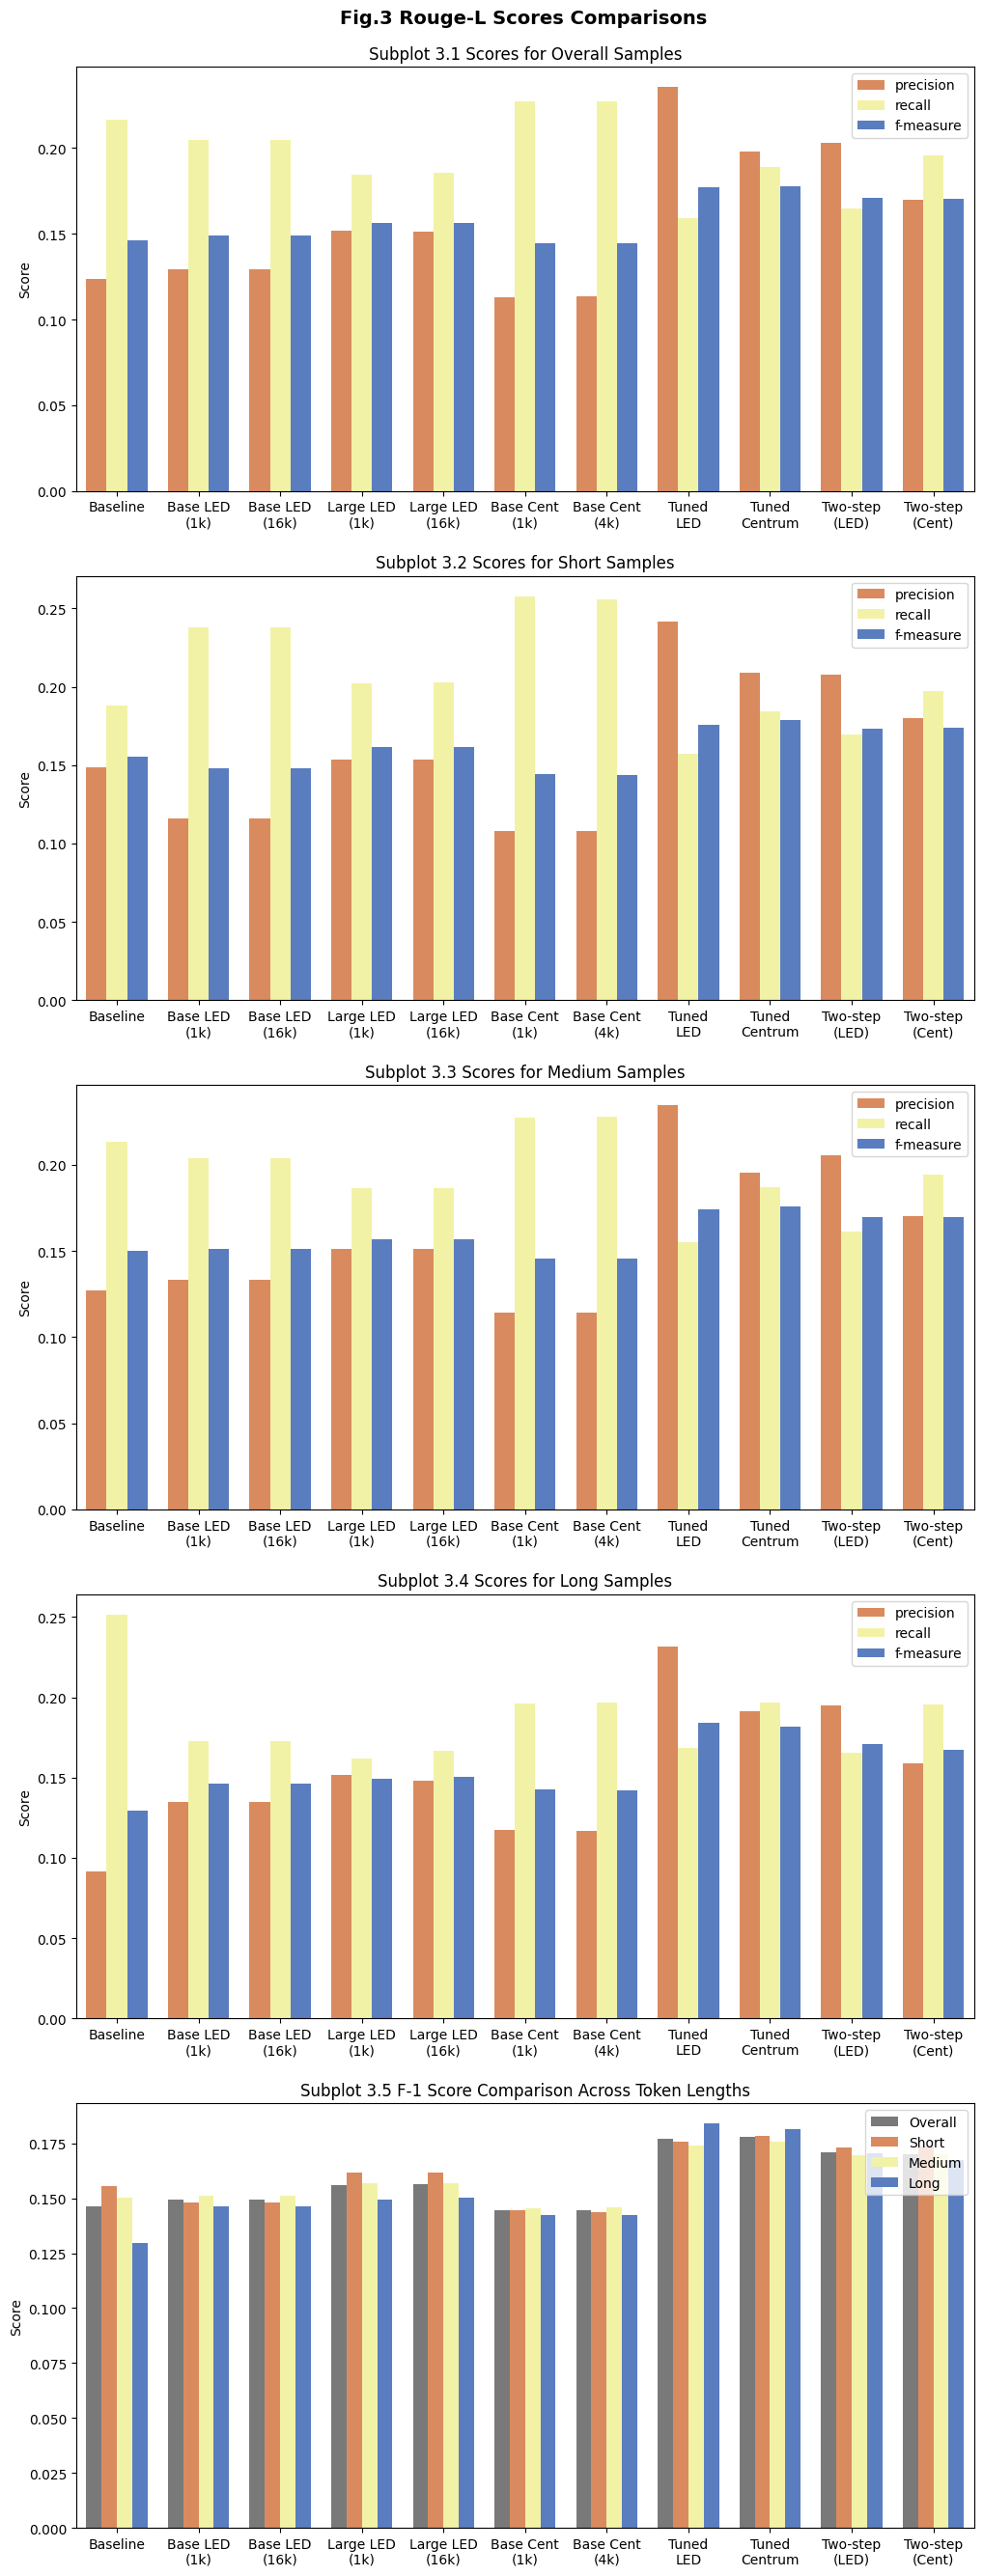

In [48]:
## Plotting results
fig, axes = plt.subplots(5, figsize=(12,30))

fig.suptitle('    Fig.3 Rouge-L Scores Comparisons',
             size=14,
             fontweight="bold")
plt.subplots_adjust(top=0.96)

for idx, subset in enumerate(['Overall', 'Short', 'Medium', 'Long']):
    sns.barplot(data=sub_df3.loc[sub_df3['Dataset'] == subset],
                x="Model",
                y="Score",
                hue="Prec/Recall/F1",
                ax=axes[idx],
                width=0.75,
                palette=[sns.color_palette("muted")[1],
                         sns.color_palette("Paired")[10],
                         sns.color_palette("muted")[0]])
    axes[idx].set_title(f'Subplot 3.{idx+1} Scores for {subset} Samples')
    axes[idx].set(xlabel=None)
    axes[idx].set_xticklabels(labels=['Baseline',
                                      'Base LED\n(1k)',
                                      'Base LED\n(16k)',
                                      'Large LED\n(1k)',
                                      'Large LED\n(16k)',
                                      'Base Cent\n(1k)',
                                      'Base Cent\n(4k)',
                                      'Tuned\nLED',
                                      'Tuned\nCentrum',
                                      'Two-step\n(LED)',
                                      'Two-step\n(Cent)'])
    axes[idx].legend(loc=1)
    
sns.barplot(data=sub_df3.loc[sub_df3['Prec/Recall/F1'] == "f-measure"],
            x="Model",
            y="Score",
            hue="Dataset",
            ax=axes[4],
            width=0.75,
            palette=[sns.color_palette("muted")[7],
                     sns.color_palette("muted")[1],
                     sns.color_palette("Paired")[10],
                     sns.color_palette("muted")[0]])
axes[4].set_title(f'Subplot 3.5 F-1 Score Comparison Across Token Lengths')
axes[4].set(xlabel=None)
axes[4].set_xticklabels(labels=['Baseline',
                                  'Base LED\n(1k)',
                                  'Base LED\n(16k)',
                                  'Large LED\n(1k)',
                                  'Large LED\n(16k)',
                                  'Base Cent\n(1k)',
                                  'Base Cent\n(4k)',
                                  'Tuned\nLED',
                                  'Tuned\nCentrum',
                                  'Two-step\n(LED)',
                                  'Two-step\n(Cent)'])
axes[4].legend(loc=1)

## 4.2 Comparing Degree of Copying

### 4.2.1 Rouge-L Scores

In [49]:
sub_df4 = scores_df.loc[(scores_df['Metric'] == 'Copying') &
                        (scores_df['Rouge_Type'] == 'rougeL') &
                        (scores_df['Low/Mid/High'] == 'mid')]

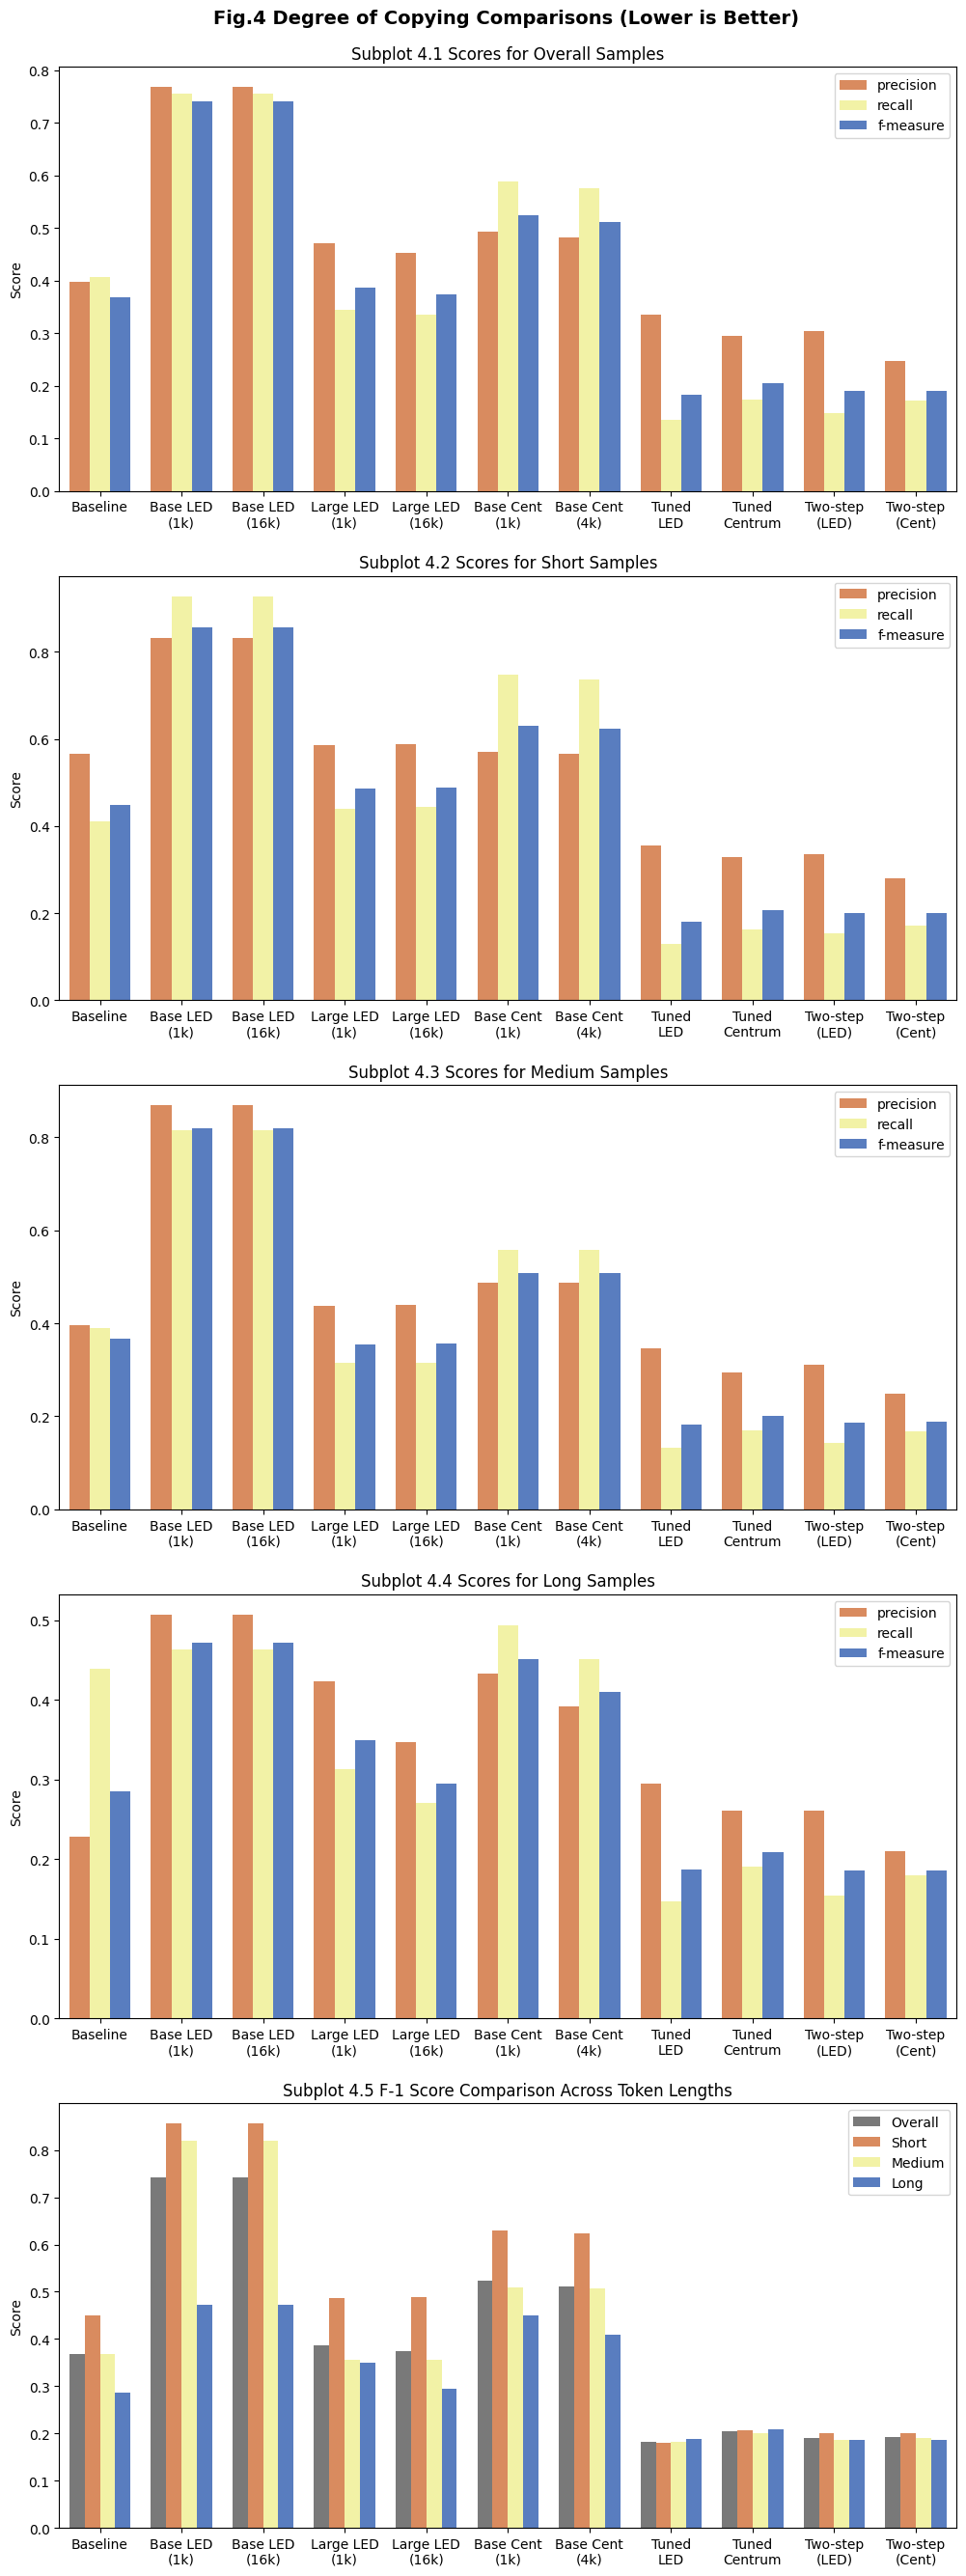

In [50]:
## Plotting results
fig, axes = plt.subplots(5, figsize=(12,30))

fig.suptitle('    Fig.4 Degree of Copying Comparisons (Lower is Better)',
             size=14,
             fontweight="bold")
plt.subplots_adjust(top=0.96)

for idx, subset in enumerate(['Overall', 'Short', 'Medium', 'Long']):
    sns.barplot(data=sub_df4.loc[sub_df4['Dataset'] == subset],
                x="Model",
                y="Score",
                hue="Prec/Recall/F1",
                ax=axes[idx],
                width=0.75,
                palette=[sns.color_palette("muted")[1],
                         sns.color_palette("Paired")[10],
                         sns.color_palette("muted")[0]])
    axes[idx].set_title(f'Subplot 4.{idx+1} Scores for {subset} Samples')
    axes[idx].set(xlabel=None)
    axes[idx].set_xticklabels(labels=['Baseline',
                                      'Base LED\n(1k)',
                                      'Base LED\n(16k)',
                                      'Large LED\n(1k)',
                                      'Large LED\n(16k)',
                                      'Base Cent\n(1k)',
                                      'Base Cent\n(4k)',
                                      'Tuned\nLED',
                                      'Tuned\nCentrum',
                                      'Two-step\n(LED)',
                                      'Two-step\n(Cent)'])
    axes[idx].legend(loc=1)
    
sns.barplot(data=sub_df4.loc[sub_df4['Prec/Recall/F1'] == "f-measure"],
            x="Model",
            y="Score",
            hue="Dataset",
            ax=axes[4],
            width=0.75,
            palette=[sns.color_palette("muted")[7],
                     sns.color_palette("muted")[1],
                     sns.color_palette("Paired")[10],
                     sns.color_palette("muted")[0]])
axes[4].set_title(f'Subplot 4.5 F-1 Score Comparison Across Token Lengths')
axes[4].set(xlabel=None)
axes[4].set_xticklabels(labels=['Baseline',
                                  'Base LED\n(1k)',
                                  'Base LED\n(16k)',
                                  'Large LED\n(1k)',
                                  'Large LED\n(16k)',
                                  'Base Cent\n(1k)',
                                  'Base Cent\n(4k)',
                                  'Tuned\nLED',
                                  'Tuned\nCentrum',
                                  'Two-step\n(LED)',
                                  'Two-step\n(Cent)'])
axes[4].legend(loc=1)